In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial
from sklearn.linear_model import LinearRegression
import copy

# Functions

In [2]:
def doy_helper(ds):
    # Remove leap day (Feb 29)
    # ds = ds.isel(
    #     time=~((pd.to_datetime(ds.time).day == 29)&(pd.to_datetime(ds.time).month == 2))
    # )
    years = np.array([ds.time.values[i].year for i in range(len(ds.time))])
    # Create day of year (DOY) array for indexing
    doy = np.tile(
        np.arange(1, 366, 1, dtype='int32'),
        len(np.unique(years))
    )

    # rework dims/coords for climo
    return ds.rename({'time':'doy'}).assign_coords({'doy':('doy', doy)})

def return_from_doy_helper(dswdoy, dswtime):

    # Remove leap day (Feb 29)
    # dswtime = dswtime.isel(
    #     time=~((pd.to_datetime(dswtime.time).day == 29)&(pd.to_datetime(dswtime.time).month == 2))
    # )

    # save time coord
    time_arr = dswtime.time.values

    # reverse to time instead of doy
    return dswdoy.assign_coords({'doy':('doy', time_arr)}).rename({'doy':'time'})

def get_climatology_smoothed(ds, var, window=60, fileauthor='Jhayron S. Pérez-Carrasquilla'):
    
    # Subset dataset for the period 1981-2020
    ds_clima = ds

    # adjust to doy coords/dims
    ds_clima = doy_helper(ds_clima)
    
    # Compute the daily mean for each day of the year
    climo = []
    for i in range(1, 366):
        daily_mean = ds_clima.sel(doy=i)[var].mean('doy')
        climo.append(daily_mean)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = ds[var].attrs
    attrs['File Author'] = fileauthor
    
    climo = xr.Dataset({
        f'{var}_climo': (['doy', 'lat', 'lon'], np.array(climo)),
    }, 
    coords={
        'doy': np.arange(1, 366, 1),
        'lat': ds.lat.values,
        'lon': ds.lon.values,
    },
    attrs=attrs
    )

    # reorder dims
    climo = climo.transpose('doy', 'lat', 'lon')

    # sanity check
    # print(climo[f'{var}_climo'].shape)
    
    # Stack climatology 3 times to handle edges
    climo_extended = xr.concat([climo, climo, climo], dim='doy')

    # Adjust coordinates after stacking to represent a larger time span
    climo_extended['doy'] = np.arange(1, 365 * 3 + 1, 1)

    # Apply rolling mean with a 60-day window for smoothing
    climo_smoothed = climo_extended.rolling(doy=window, center=True, min_periods=1).mean(skipna=True)

    # Extract the middle portion, corresponding to the original 365 days
    climo_smoothed = climo_smoothed.isel(doy=slice(365, 365 + 365))

    # sanity check
    # print(climo_smoothed[f'{var}_climo'].shape)
    
    # Reset 'day_of_year' coordinate to original range
    climo_smoothed['doy'] = np.arange(1, 366, 1)

    return climo_smoothed

def get_anomalies(ds, var, climo):

    # deep copy dataset
    anom = copy.deepcopy(ds)

    # adjust to doy coords/dims
    dstmp = doy_helper(ds)
    anom = doy_helper(anom)

    # compute doy anomalies
    for day in range(1, 366):
        
        anom[var][{'doy':(dstmp.doy == day)}] = (dstmp[var].sel(doy=day) - climo[f'{var}_climo'].sel(doy=day))

    # back to dataset
    anom = anom.rename({var:f'{var}_anom'})

    # add original time dim
    return return_from_doy_helper(anom, ds)

def fourierfilter(da, cutoff_period=10):
    
    # Compute the Fourier transform along the time axis
    fft_data = np.fft.fft(da, axis=0)
    
    # Get the frequencies corresponding to the FFT components
    freqs = np.fft.fftfreq(da.shape[0], d=1)
    # d=1 assumes daily data; adjust if different
    
    # Compute the corresponding periods (in days)
    periods = np.abs(1 / freqs)
    
    # Define the cutoff period for low-pass filter (10 days)
    cutoff_period = cutoff_period
    
    # Create a mask to filter out high-frequency components (shorter than 10 days)
    high_pass_mask = periods < cutoff_period
    
    # Apply the mask to the FFT data (set high-frequency components to zero)
    fft_data_filtered = fft_data.copy()
    fft_data_filtered[high_pass_mask, :, :] = 0
    
    # Perform the inverse FFT to get the filtered data back in the time domain
    filtered_data = np.fft.ifft(fft_data_filtered, axis=0).real
    
    # Create a new xarray DataArray to store the filtered data
    filtered_anom = xr.DataArray(
        filtered_data,
        dims=da.dims,
        coords=da.coords,
        attrs=da.attrs
    )
    return filtered_anom

# Get average time series of the region
def get_weighted_area_average(da):
    
    # Compute the cosine of the latitudes (in radians) for weighting
    # For a rectangular grid the cosine of the latitude is proportional to the grid cell area
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"

    # Apply the weights and compute the mean across lat/lon
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean(dim=['lat', 'lon'])
    
    return weighted_mean


def create_doy_dummy(num_yr=84):
    """Creates dummy array for indexing the non-leap year based doy time series"""
    days_per_year = 365
    years = num_yr
    day_indices = np.arange(
        0, 
        years * days_per_year, 
        days_per_year,
        dtype=int
    ).reshape(-1, 1) + np.arange(days_per_year)
    return day_indices


def get_climatology_std_smoothed(ds, var, window=60, fileauthor='Jhayron S. Pérez-Carrasquilla'):

    # Get the day of year (DOY)
    doy_tmp = create_doy_dummy(len(np.unique(years_full)))
    
    # Compute the daily standard deviation for each day of the year
    climo = []
    for i in range(0, 365):
        # grab indices for doy
        doy_indx = doy_tmp[:, i]
        
        # ensure time is first axis with transpose
        array_temp = ds[var].transpose('time', 'lat', 'lon')[doy_indx]

        # compute std for doy
        std = np.nanstd(array_temp, axis=0)
        # make nan where 0
        std[std == 0] = np.nan
        climo.append(std)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = ds[var].attrs
    attrs['File Author'] = fileauthor
    
    climo = xr.Dataset({
        f'{var}_climo_std': (['doy', 'lat', 'lon'], np.array(climo)),
    }, 
    coords={
        'doy': np.arange(1, 366, 1),
        'lat': ds.lat.values,
        'lon': ds.lon.values,
    },
    attrs=attrs)

    climo = climo.transpose('doy', 'lat', 'lon')
    
    # Stack climatology 3 times to handle edges
    climo_extended = xr.concat([climo, climo, climo], dim='doy')

    # Adjust coordinates after stacking to represent a larger time span
    climo_extended['doy'] = np.arange(1, 365 * 3 + 1, 1)

    # Apply rolling mean with a 60-day window for smoothing
    climo_smoothed = climo_extended.rolling(doy=window, center=True, min_periods=1).mean(skipna=True)

    # Extract the middle portion, corresponding to the original 365 days
    climo_smoothed = climo_smoothed.isel(doy=slice(365, 365 + 365))

    # Reset 'day_of_year' coordinate to original range
    climo_smoothed['doy'] = np.arange(1, 366, 1)

    return climo_smoothed

# this func is not used (below)
def standardize_anomalies(anom, var, climo_std):

    # ensure time is first dim/axis
    anom = anom.transpose('time', 'lat', 'lon')
    std_anom = copy.deepcopy(anom)
    
    # Get the day of year (DOY)
    doy_tmp = create_doy_dummy(len(np.unique(years_full)))

    for i in range(0, 365):
        
        doy_indx = doy_tmp[:, i]

        std_anom[var][doy_indx] = (
            anom[var][doy_indx] / climo_std[f'{var}_climo_std'].sel(doy=i + 1)
        )
    return std_anom

In [3]:
def extractz500_several_files(filestemp):
    listxarrays = []
    for file in filestemp:
        dstemp = xr.open_dataset(file)
        dstemp = regridz500intolens2grid(dstemp,lat_lens2,lon_lens2)
        # dstemp = dstemp.sel(time=slice('1850-01-01', '2100-12-31'))
        # dstemp = dstemp.Z500.where((dstemp.lat>=10),drop=True)
        # Transpose the data to match the desired dimension order
        dstemp_transposed = dstemp.transpose('time', 'lat', 'lon')
        lat0=20; lat1=80; lon0=180; lon1=330
        dstemp_transposed = dstemp_transposed.where((dstemp_transposed.lat>=lat0)&(dstemp_transposed.lat<=lat1)&\
                               (dstemp_transposed.lon>=lon0)&(dstemp_transposed.lon<=lon1),drop=True)
        
        # Recreate the DataArray with the coordinates in the desired order
        dstemp_reordered = xr.DataArray(
            dstemp_transposed.values,
            dims=['time', 'lat', 'lon'],
            coords={
                'time': dstemp_transposed.coords['time'],
                'lat': dstemp_transposed.coords['lat'],
                'lon': dstemp_transposed.coords['lon']
            },
            attrs=dstemp.attrs,
            name=dstemp.name
        )
        listxarrays.append(dstemp_reordered)
    xarrayfull = xr.concat(listxarrays, dim='time')
    xarrayfull = xarrayfull.drop_duplicates('time',keep='first')
    xarrayfull = xarrayfull.sortby('time')
    cftime_index = xr.coding.cftimeindex.CFTimeIndex(xarrayfull['time'].values)
    datetime_index = cftime_index.to_datetimeindex()
    xarrayfull.coords['time'] = datetime_index
    return xarrayfull.to_dataset()

In [4]:
from scipy.spatial import cKDTree

def regridz500intolens2grid(ds,lat_lens2,lon_lens2):
    # Step 1: Flatten original coordinates
    lat_flat = ds.lat.values.flatten()  # shape: (ncol,)
    lon_flat = ds.lon.values.flatten()  # shape: (ncol,)
    
    # Step 2: Prepare new grid
    lon_grid, lat_grid = np.meshgrid(lon_lens2, lat_lens2)
    target_points = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])  # shape: (new_ncol, 2)
    
    # Step 3: KDTree for nearest neighbor search
    tree = cKDTree(np.column_stack([lat_flat, lon_flat]))
    _, nearest_idx = tree.query(target_points)  # indices of original points closest to new grid
    
    # Step 4: Rebuild new DataArray
    # Z500: shape (time, ncol)
    Z500_new_flat = ds.Z500.values[:, nearest_idx]  # shape (time, new_ncol)
    Z500_new = Z500_new_flat.reshape((ds.Z500.shape[0], len(lat_lens2), len(lon_lens2)))  # shape: (time, lat, lon)
    
    # Step 5: Wrap in xarray
    Z500_regridded = xr.DataArray(
        Z500_new,
        coords={
            "time": ds.Z500.time,
            "lat": lat_lens2,
            "lon": lon_lens2
        },
        dims=["time", "lat", "lon"],
        name="Z500"
    )
    return Z500_regridded

In [5]:
ds_lens2 = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS2_full_Z500_Anoms/anoms_LE2-1001.001_cmip6.nc')
lat_lens2 = ds_lens2.lat
lon_lens2 = ds_lens2.lon

# Compute anomalies

In [6]:
path_files = '/glade/campaign/collections/rda/data/d651029/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/atm/proc/tseries/day_1/'
filenames = np.sort(glob.glob(f'{path_files}*Z500*.nc'))

In [7]:
len(filenames)

19

In [8]:
# filestemp = filenames
# listxarrays = []
# for file in filestemp:
#     dstemp = xr.open_dataset(file)
#     dstemp = regridz500intolens2grid(dstemp,lat_lens2,lon_lens2)
#     # aaa
#     # dstemp = dstemp.sel(time=slice('1850-01-01', '2100-12-31'))
#     # dstemp = dstemp.Z500.where((dstemp.lat>=10),drop=True)
#     # Transpose the data to match the desired dimension order
#     dstemp_transposed = dstemp.transpose('time', 'lat', 'lon')
#     lat0=20; lat1=80; lon0=180; lon1=330
#     dstemp_transposed = dstemp_transposed.where((dstemp_transposed.lat>=lat0)&(dstemp_transposed.lat<=lat1)&\
#                            (dstemp_transposed.lon>=lon0)&(dstemp_transposed.lon<=lon1),drop=True)
    
#     # Recreate the DataArray with the coordinates in the desired order
#     dstemp_reordered = xr.DataArray(
#         dstemp_transposed.values,
#         dims=['time', 'lat', 'lon'],
#         coords={
#             'time': dstemp_transposed.coords['time'],
#             'lat': dstemp_transposed.coords['lat'],
#             'lon': dstemp_transposed.coords['lon']
#         },
#         attrs=dstemp.attrs,
#         name=dstemp.name
#     )
#     listxarrays.append(dstemp_reordered)

# xarrayfull = xr.concat(listxarrays, dim='time')
# xarrayfull = xarrayfull.drop_duplicates('time',keep='first')
# xarrayfull = xarrayfull.sortby('time')

# xarrayfull.to_netcdf('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM1HR_pi_Z500.nc')

In [47]:
xarrayfull = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM1HR_pi_Z500.nc')

In [48]:
xarrayfull = xarrayfull.drop_duplicates('time',keep='first')
# cftime_index = xr.coding.cftimeindex.CFTimeIndex(xarrayfull['time'].values)
# datetime_index = cftime_index.to_datetimeindex()
# xarrayfull.coords['time'] = datetime_index

In [49]:
lat0=20; lat1=80; lon0=180; lon1=330
dataset_region = xarrayfull.where(
    (
        xarrayfull.lat>=lat0)&(
            xarrayfull.lat<=lat1)&(
            xarrayfull.lon>=lon0)&(
            xarrayfull.lon<=lon1),
    drop=True
)
dataset_region = dataset_region.sel(time=slice('0339','0512'))

In [50]:
import cftime

In [51]:
newtime = []
for timei in range(len(dataset_region.time)):
    # Original object
    t0 = dataset_region.time.values[timei]
    if t0.year<=377:
        # Change the year to 400
        t1 = cftime.DatetimeNoLeap(
            t0.year+1,                         # new year
            t0.month,
            t0.day,
            t0.hour,
            t0.minute,
            t0.second,
            t0.microsecond,
            has_year_zero=t0.has_year_zero
        )
    else:
        t1 = t0
    newtime.append(t1)

In [54]:
dataset_region = dataset_region.assign_coords(time=("time", np.array(newtime)))

In [56]:
years = np.array([dataset_region.time.values[i].year for i in range(len(dataset_region.time))])

In [57]:
for year in np.unique(years):
    print(year,len(np.where(years==year)[0]))

340 365
341 365
342 365
343 365
344 365
345 365
346 365
347 365
348 365
349 365
350 365
351 365
352 365
353 365
354 365
355 365
356 365
357 365
358 365
359 365
360 365
361 365
362 365
363 365
364 365
365 365
366 365
367 365
368 365
369 365
370 365
371 365
372 365
373 365
374 365
375 365
376 365
377 365
378 365
379 365
380 365
381 365
382 365
383 365
384 365
385 365
386 365
387 365
388 365
389 365
390 365
391 365
392 365
393 365
394 365
395 365
396 365
397 365
398 365
399 365
400 365
401 365
402 365
403 365
404 365
405 365
406 365
407 365
408 365
409 365
410 365
411 365
412 365
413 365
414 365
415 365
416 365
417 365
418 365
419 365
420 365
421 365
422 365
423 365
424 365
425 365
426 365
427 365
428 365
429 365
430 365
431 365
432 365
433 365
434 365
435 365
436 365
437 365
438 365
439 365
440 365
441 365
442 365
443 365
444 365
445 365
446 365
447 365
448 365
449 365
450 365
451 365
452 365
453 365
454 365
455 365
456 365
457 365
458 365
459 365
460 365
461 365
462 365
463 365
464 365


In [58]:
clima = get_climatology_smoothed(dataset_region, 'Z500')

In [59]:
anoms = get_anomalies(dataset_region, 'Z500', clima)

In [60]:
anoms_filtered = fourierfilter(anoms.Z500_anom)

/glade/derecho/scratch/jhayron/tmp/ipykernel_58201/1559490235.py:114: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [61]:
del(anoms)
del(clima)

In [62]:
anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')

In [63]:
# anoms_filtered.to_netcdf('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_pi/pi_Z500anoms_filtered.nc')

In [64]:
anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)


In [65]:
# anoms_smooth.to_netcdf('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_pi/pi_Z500anoms_smooth.nc')

In [66]:
mean_series = get_weighted_area_average(anoms_smooth.Z_anom)

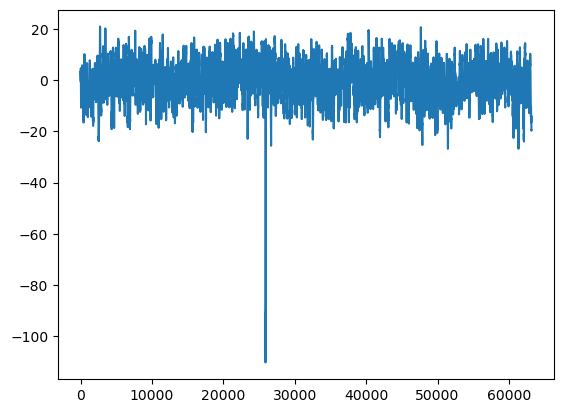

In [67]:
plt.plot(mean_series)

In [68]:
years_full = np.array([mean_series.time[i].time.values[()].year for i in range(len(mean_series.time))])

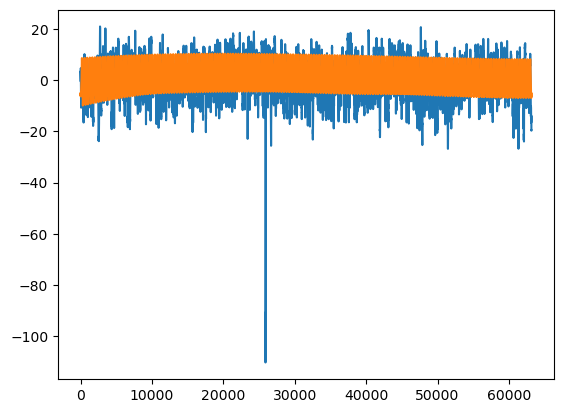

In [69]:
full_curve = copy.deepcopy(mean_series)
full_curve.data = np.zeros(len(full_curve))
npoly=3

doy_tmp = create_doy_dummy(len(np.unique(years_full)))

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]
    
    # fit a polynomial for the trend of each DOY
    params_curve = polynomial.polyfit(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        mean_series[doy_indx], 
        npoly
    )
    curve = polynomial.polyval(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        params_curve, 
        tensor=True
    )
    
    ## Center curve in zero
    full_curve.loc[{'time': mean_series[doy_indx].time}] = curve

plt.plot(mean_series)
plt.plot(full_curve)
plt.show()
plt.close('all')

In [70]:
anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]
anoms_detrended = anoms_detrended.to_dataset()

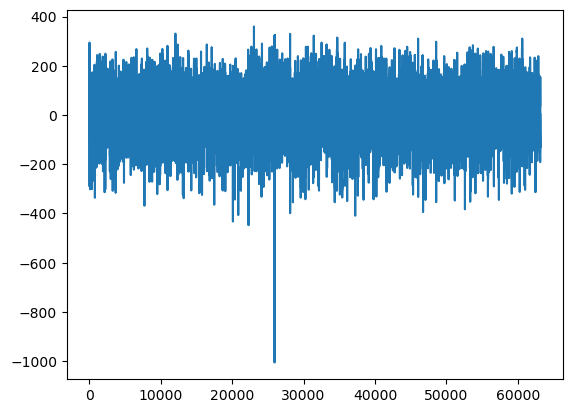

In [71]:
plt.plot(anoms_detrended.isel(lat=30,lon=50).Z_anom)

In [72]:
del(anoms_filtered)

In [73]:
clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
clima_std_average_region_series = get_weighted_area_average(clima_std)



In [74]:
anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
anoms_standardized.data = np.zeros_like(anoms_standardized.data)

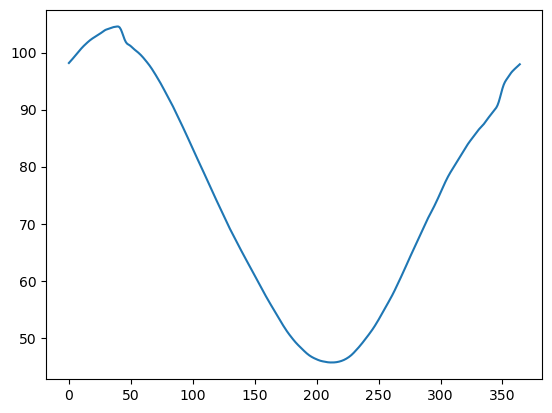

In [75]:
plt.plot(clima_std_average_region_series.Z_anom_climo_std)

In [76]:
doy_tmp = create_doy_dummy(len(np.unique(years_full)))

In [77]:
for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]

    # grab doy std (climo)
    std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
    # standardize the detrended anoms by std climo
    standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
    anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp

In [78]:
# anoms_standardized = anoms_standardized.to_dataset()
anoms_standardized.to_netcdf(f'/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM1HR_pi/anoms_standardized.nc')

In [73]:
id_experiment = 0
name_experiment = unique_names_experiments[id_experiment]
print(name_experiment)
where_files = np.where(names_experiments_all==name_experiment)[0]
files_temp = filenames[where_files]
dataset_raw = extractz500_several_files(files_temp)

LE2-1001.001_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_52022/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


In [74]:
lat0=20; lat1=80; lon0=180; lon1=330
dataset_region = dataset_raw.where(
    (
        dataset_raw.lat>=lat0)&(
            dataset_raw.lat<=lat1)&(
            dataset_raw.lon>=lon0)&(
            dataset_raw.lon<=lon1),
    drop=True
)

In [77]:
clima = get_climatology_smoothed(dataset_region, 'Z500')
anoms = get_anomalies(dataset_region, 'Z500', clima)

(365, 64, 121)
(365, 64, 121)


In [82]:
anoms_filtered = fourierfilter(anoms.Z500_anom)
anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')

/glade/derecho/scratch/jhayron/tmp/ipykernel_52022/4011791934.py:110: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [88]:
anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)
mean_series = get_weighted_area_average(anoms_smooth.Z_anom)
full_curve = copy.deepcopy(mean_series)
full_curve.data = np.zeros(len(full_curve))
npoly=3

doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]
    
    # fit a polynomial for the trend of each DOY
    params_curve = polynomial.polyfit(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        mean_series[doy_indx], 
        npoly
    )
    curve = polynomial.polyval(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        params_curve, 
        tensor=True
    )
    
    ## Center curve in zero
    full_curve.loc[{'time': mean_series[doy_indx].time}] = curve

anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]
anoms_detrended = anoms_detrended.to_dataset()

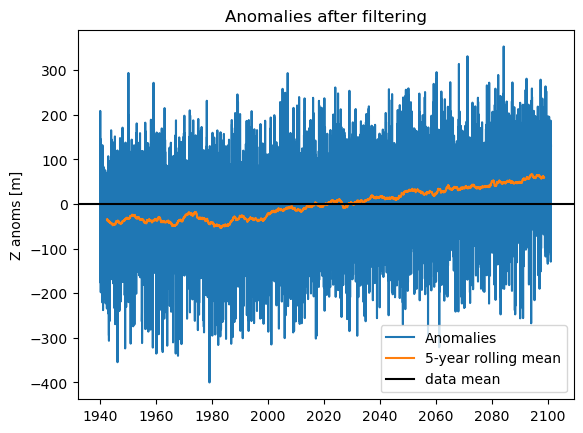

In [84]:
example_time_series = anoms_filtered.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')
plt.plot(
    example_time_series.time, 
    example_time_series, 
    label='Anomalies'
)
plt.plot(
    example_time_series.time, 
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True), 
    label='5-year rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='data mean'
)
plt.title('Anomalies after filtering')
plt.ylabel('Z anoms [m]')
plt.legend()
plt.show()

Text(0, 0.5, 'Z [m]')

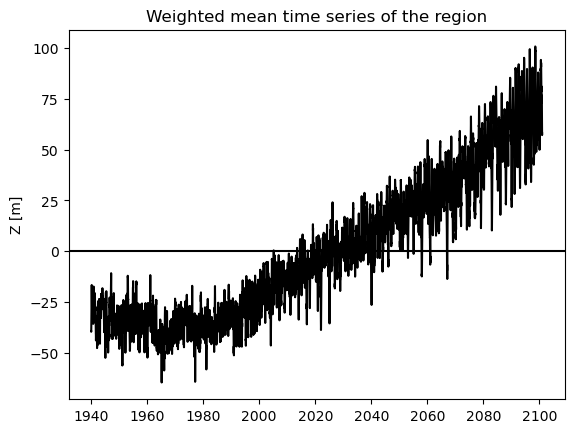

In [89]:
plt.plot(
    mean_series.time,
    mean_series,
    color='k'
)
plt.axhline(
    np.mean(mean_series),
    color='k'
)
plt.title('Weighted mean time series of the region')
plt.ylabel('Z [m]')

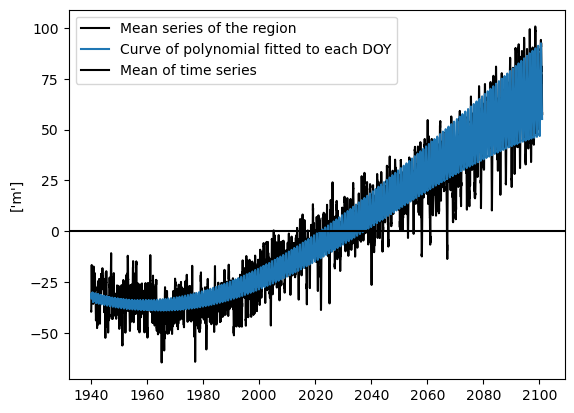

In [90]:
plt.plot(
    mean_series.time,
    mean_series,
    color='k',
    label='Mean series of the region'
)
plt.plot(
    full_curve.time,
    full_curve,
    label='Curve of polynomial fitted to each DOY'
)
plt.axhline(
    np.mean(mean_series),
    color='k',
    label='Mean of time series'
)
plt.ylabel(['m'])
plt.legend()
plt.show()

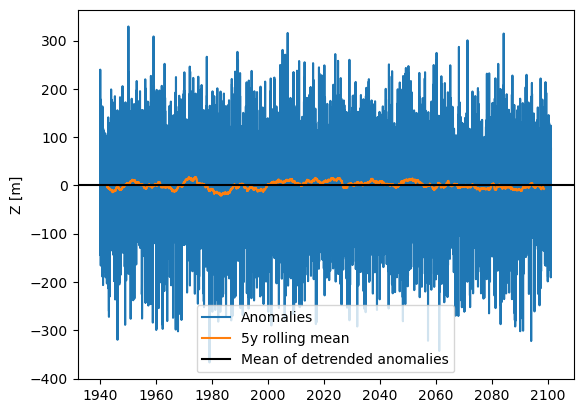

In [92]:
example_time_series = anoms_detrended.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')

plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5 * 365,center=True).mean(skipna=True),
    label='5y rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='Mean of detrended anomalies'
)
plt.legend()
plt.ylabel('Z [m]')
plt.show()

In [93]:
clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
clima_std_average_region_series = get_weighted_area_average(clima_std)

anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
anoms_standardized.data = np.zeros_like(anoms_standardized.data)

doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]

    # grab doy std (climo)
    std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
    
    # standardize the detrended anoms by std climo
    standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
    
    anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp

anoms_standardized = anoms_standardized.to_dataset()

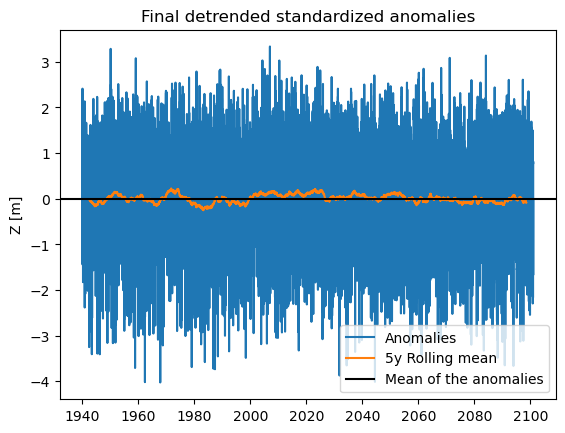

In [95]:
example_time_series = anoms_standardized.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')

plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True),
    label='5y Rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='Mean of the anomalies'
)
plt.legend()
plt.ylabel('Z [m]')
plt.title('Final detrended standardized anomalies')
plt.show()

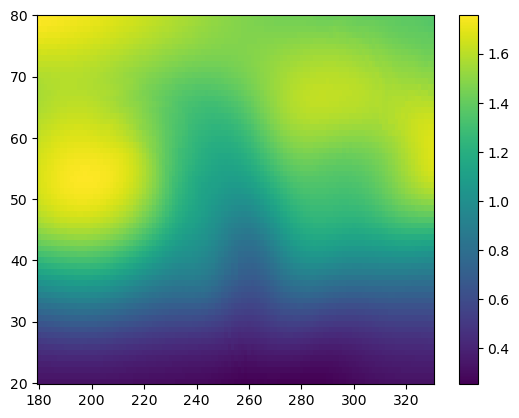

In [98]:
plt.pcolormesh(anoms_standardized.lon,anoms_standardized.lat,anoms_standardized.std('time').Z_anom)
plt.colorbar()
plt.show()

In [53]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
name_reanalysis = 'ERA5'

for name_reanalysis in ['ERA5','JRA3Q','NCEP_NCAR']:
    dataset_raw = xr.open_dataset(
        f'{path_origins}Z500_{name_reanalysis}.nc'
    )
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset_region = dataset_raw.where(
        (
            dataset_raw.lat>=lat0)&(
                dataset_raw.lat<=lat1)&(
                dataset_raw.lon>=lon0)&(
                dataset_raw.lon<=lon1),
        drop=True
    )
    
    dataset_region.Z.data = dataset_region.Z.data / 9.82 ### Divide by gravity to convert from m2/s2 to m
    
    clima = get_climatology_smoothed(dataset_region, 'Z')
    anoms = get_anomalies(dataset_region, 'Z', clima)
    
    anoms_filtered = fourierfilter(anoms.Z_anom)
    anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')
    anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)
    mean_series = get_weighted_area_average(anoms_smooth.Z_anom)
    full_curve = copy.deepcopy(mean_series)
    full_curve.data = np.zeros(len(full_curve))
    npoly=3
    
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))
    
    for i in range(0, 365): #Iterate through every day of the year
    
        doy_indx = doy_tmp[:, i]
        
        # fit a polynomial for the trend of each DOY
        params_curve = polynomial.polyfit(
            np.arange(0, mean_series[doy_indx].shape[0]), 
            mean_series[doy_indx], 
            npoly
        )
        curve = polynomial.polyval(
            np.arange(0, mean_series[doy_indx].shape[0]), 
            params_curve, 
            tensor=True
        )
        
        ## Center curve in zero
        full_curve.loc[{'time': mean_series[doy_indx].time}] = curve
    
    anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]
    anoms_detrended = anoms_detrended.to_dataset()
    clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
    clima_std_average_region_series = get_weighted_area_average(clima_std)
    
    anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
    anoms_standardized.data = np.zeros_like(anoms_standardized.data)
    
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))
    
    for i in range(0, 365): #Iterate through every day of the year
    
        doy_indx = doy_tmp[:, i]
    
        # grab doy std (climo)
        std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
        
        # standardize the detrended anoms by std climo
        standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
        
        anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp
    
    anoms_standardized = anoms_standardized.to_dataset()
    anoms_standardized.to_netcdf(f'{path_origins}Z500Anoms_{name_reanalysis}.nc')

(365, 61, 151)
(365, 61, 151)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


(365, 61, 151)
(365, 61, 151)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


(365, 25, 61)
(365, 25, 61)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
